In [1]:
import wandb
import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm
font_path = 'analyses/font_arial.ttf'
fm.fontManager.addfont(font_path)
plt.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 12})

# Get wandb run history
api = wandb.Api()
wandb_path = os.path.join("..", "wandb")

In [5]:
weight_decays = [0.0, 0.00001, 0.0001, 0.001, 0.002, 0.004]
random_strings = ["WD_4", "WD_5", "WD_6", "WD_7", "WD_8", "WD_9"]

# Initialize histories dict
histories = {wd: [] for wd in weight_decays}

# Generate all run IDs and collect histories
for wd in weight_decays:
    for rs in random_strings:
        run_id = f"M_nst8_iN_dm192_nh12_nl5_5_dr0.2_bs100_wd{wd}_lr0.002_optMuon_r{rs}"
        
        runs = api.runs("andrii-mit/mini_bfm_exp", filters={"display_name": run_id})
        if len(runs) > 0:
            run = runs[0]
            history = run.history()
            if history['_step'].max() == 99:  # Only include if trained for full 100 epochs
                histories[wd].append(history)

for wd in weight_decays:
    print(f"weight decay {wd}: {len(histories[wd])} runs")

weight decay 0.0: 6 runs
weight decay 1e-05: 6 runs
weight decay 0.0001: 6 runs
weight decay 0.001: 6 runs
weight decay 0.002: 3 runs
weight decay 0.004: 2 runs


In [6]:
metrics = ['train_loss', 'test_loss', 'eval_auroc/average_speech', 'eval_auroc/average_volume']
metric_names = ['Training Loss', 'Test Loss', 'Decoding Speech AUROC', 'Decoding Volume AUROC']
n_last_measurements = 3

# Initialize results dictionary
results = {wd: {metric: [] for metric in metrics} 
          for wd in weight_decays}

# Calculate means for each run
for wd in weight_decays:
    for history in histories[wd]:
        for metric in metrics:
            results[wd][metric].append(history[metric].iloc[-n_last_measurements:].mean())

# Print results
for wd in weight_decays:
    print(f"\nweight decay {wd}:")
    for metric in metrics:
        values = results[wd][metric]
        if values:
            mean = sum(values) / len(values)
            print(f"{metric}: {mean:.4f} (across {len(values)} runs)")



weight decay 0.0:
train_loss: 0.2909 (across 6 runs)
test_loss: 0.4340 (across 6 runs)
eval_auroc/average_speech: 0.8444 (across 6 runs)
eval_auroc/average_volume: 0.7057 (across 6 runs)

weight decay 1e-05:
train_loss: 0.2932 (across 6 runs)
test_loss: 0.4391 (across 6 runs)
eval_auroc/average_speech: 0.8401 (across 6 runs)
eval_auroc/average_volume: 0.7165 (across 6 runs)

weight decay 0.0001:
train_loss: 0.2889 (across 6 runs)
test_loss: 0.4382 (across 6 runs)
eval_auroc/average_speech: 0.8368 (across 6 runs)
eval_auroc/average_volume: 0.6885 (across 6 runs)

weight decay 0.001:
train_loss: 0.2929 (across 6 runs)
test_loss: 0.4365 (across 6 runs)
eval_auroc/average_speech: 0.8417 (across 6 runs)
eval_auroc/average_volume: 0.6969 (across 6 runs)

weight decay 0.002:
train_loss: 0.5840 (across 3 runs)
test_loss: 0.5903 (across 3 runs)
eval_auroc/average_speech: 0.8371 (across 3 runs)
eval_auroc/average_volume: 0.6968 (across 3 runs)

weight decay 0.004:
train_loss: 90.4853 (across 2 

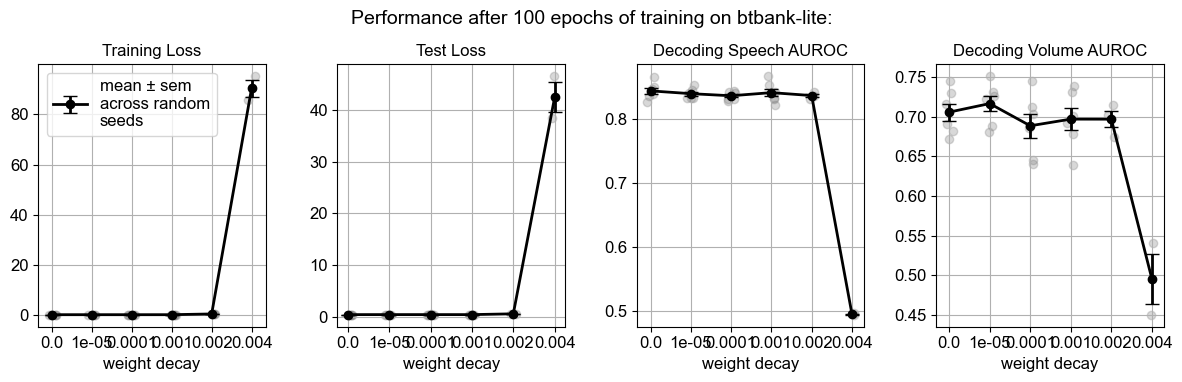

In [7]:
# Set error bar type ('std' for standard deviation or 'sem' for standard error of mean)
error_type = 'sem'

fig, axes = plt.subplots(1, len(metrics), figsize=(3*len(metrics), 4))

for i, metric in enumerate(metrics):
    means = []
    errors = []
    wds = []
    all_values = []
    all_wds = []
    
    for idx, wd in enumerate(weight_decays):
        values = results[wd][metric]
        if values:  # Only include if we have data
            means.append(np.mean(values))
            if error_type == 'std':
                errors.append(np.std(values))
            else:  # sem
                errors.append(np.std(values) / np.sqrt(len(values)))
            wds.append(idx)  # Use index instead of actual weight decay value
            # Store individual points
            all_values.extend(values)
            all_wds.extend([idx] * len(values))
    
    # Plot individual points with some jitter and transparency
    jitter = 0.1
    axes[i].scatter(
        [w + np.random.uniform(-jitter, jitter) for w in all_wds],
        all_values,
        alpha=0.3,
        color='gray',
        zorder=1
    )
    
    # Plot mean and error bars on top
    error_label = 'mean ± std' if error_type == 'std' else 'mean ± sem'
    error_label += '\nacross random\nseeds'
    axes[i].errorbar(wds, means, yerr=errors, marker='o', capsize=5, 
                    color='black', zorder=2, label=error_label,
                    linewidth=2)
    
    # Set x-ticks at indices but label with actual weight decay values
    axes[i].set_xticks(range(len(weight_decays)))
    axes[i].set_xticklabels(weight_decays)
    axes[i].set_xlabel('weight decay')
    axes[i].set_title(metric_names[i], color='black', fontsize=12)
    axes[i].grid(True)
    if i==0: axes[i].legend()

plt.suptitle('Performance after 100 epochs of training on btbank-lite:', color='black', fontsize=14, y=0.95)
plt.tight_layout()
plt.savefig('analyses/exp_wd.pdf', bbox_inches='tight', dpi=300)
plt.show()
